In [23]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import random
import pandas as pd
import multiprocessing as mp
import numpy as np
import osmnx as ox
import json
import networkx as nx
import pickle
from data_utils import *
import matplotlib

from scipy.stats import pearsonr
from scipy.stats import ttest_rel, ttest_ind
from scipy.stats import friedmanchisquare
from scipy.stats import shapiro
import matplotlib.pyplot as plt

## Démarche 

### Test students : comparaison score moyen courts / frais
### Trade off distance / fraîcheur
### Caractérisation des segments les plus fréquentés
#### ACP
#### Distribution des proportions / comparaison avec distribution initiale

In [65]:
edges_buffer_scored_path = "output_data/analyse/edges_all_prop.gpkg"
edges_prop = gpd.read_file(edges_buffer_scored_path)
edges_prop.head()

,u,v,key,osmid,oneway,name,highway,maxspeed,reversed,length,...,prairies_prop,ombres_08_prop,ombres_13_prop,ombres_18_prop,arbustes_prop,arbres_prop,C_wavg_scaled,eaux_prop,canop,geometry
0,143403,21714981,0,120412669,False,Rue Professeur Morat,residential,30,False,12.119,...,0.0,0.00,0.0,0.00,0.0,0.60,0.588824,0.0,0.0,"POLYGON ((1846109.564 5172145.602, 1846110.144..."
1,143403,9226919131,0,521119804,True,Avenue Jean Mermoz,primary,50,False,26.832,...,0.0,0.00,0.0,0.00,0.0,0.91,0.588824,0.0,0.0,"POLYGON ((1846084.687 5172144.567, 1846084.135..."
2,143403,9226887756,0,120412669,False,Rue Professeur Morat,residential,30,True,11.073,...,0.0,0.76,0.0,0.00,0.0,0.30,0.588824,0.0,0.0,"POLYGON ((1846122.675 5172142.519, 1846122.463..."
3,143403,10810932922,0,521119804,True,Avenue Jean Mermoz,primary,50,False,15.606,...,0.0,0.36,0.0,0.00,0.0,0.72,0.588824,0.0,0.0,"POLYGON ((1846109.345 5172134.084, 1846108.797..."
4,21714981,9226922647,0,4087154,True,Rue Professeur Morat,unclassified,30,False,8.969,...,0.0,0.00,0.0,0.69,0.0,0.32,0.592353,0.0,0.0,"POLYGON ((1846096.611 5172125.102, 1846096.085..."


In [66]:
edges_prop = edges_prop.set_index(["u", "v", "key"])

## ALL 1
Tous les poids des variables sont à 1. 

### Test students

In [52]:
def len_if_group(all_it_path):
    all_it = pd.read_csv(all_it_path)

    it_if = all_it[all_it["type"] == "IF"]
    it_len = all_it[all_it["type"] == "LEN"]
    
    return it_if, it_len

def test_students(group1, group2):
    """In order to compare the mean between the distribution of group 1 and group 2"""
    return ttest_rel(group1, group2)

def d_cohen(group1, group2):
    """In order to know if there is a size effect"""
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)

    var1 = np.var(group1, ddof=1)
    var2 = np.var(group2, ddof=2)
    
    n1 = len(group1)
    n2 = len(group2)

    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

    return (mean1 - mean2) / pooled_std

def distance_cost(group1, group2):
    """Calculate the distance cost between itineraries"""
    d1 = np.array(group1["total_length"])
    d2 = np.array(group2["total_length"])

    percent_diff = ((d2-d1)/d1)*100

    return round(np.mean(percent_diff),2)

def select_most_frequent_index(frequency_data, quantile):
    limit_count = frequency_data["count"].quantile([quantile]).iloc[0]
    most_frequent = frequency_data[frequency_data["count"] >= limit_count]
    
    percent = (len(most_frequent)/len(frequency_data))*100
    
    print(f"percent most frequent :", percent)
    
    indexes_most_frequent = most_frequent.index.to_list()
    
    return indexes_most_frequent

In [12]:
all_it_path = "./output_data/analyse/mean_score_all_1.csv"

it_if, it_len = len_if_group(all_it_path)
print(f"Test de student : {test_students(it_len['score'], it_if['score'])}")
print(f"D de cohen : {d_cohen(it_len['score'], it_if['score'])}")

print(f"Coût de distance : ", distance_cost(it_len, it_if))

Test de student : TtestResult(statistic=19.920886775025647, pvalue=7.579503350200604e-79, df=1559)
D de cohen : 0.2521224960231628
Coût de distance :  0.56


Test de student OK mais pas d de cohen => peu d'effet de la fraîcheur

Un coût de distance très négligeable : moins de 1%
La différence entre les deux types d'itinéraires n'est pas flagrante. Logique à priori.

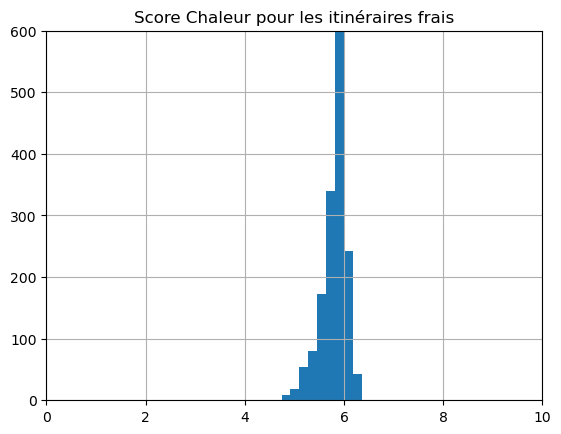

In [16]:
it_if["score"].hist()
plt.xlim([0,10])
plt.ylim([0,600])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

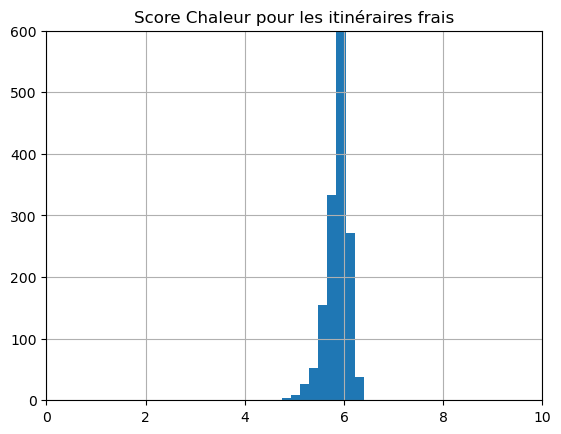

In [17]:
it_len["score"].hist()
plt.xlim([0,10])
plt.ylim([0,600])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

Avec des poids à 1 pour chacune des données, on observe clairement la même distribution au niveau des scores.

### Analyse des segments les plus fréquentés

In [55]:
frequency_if_path = "./output_data/analyse/frequency_if_all_1.gpkg"
frequency_len_path = "./output_data/analyse/frequency_len_all_1.gpkg"
frequency_if = gpd.read_file(frequency_if_path)
frequency_len = gpd.read_file(frequency_len_path)

frequency_if = frequency_if.set_index(["u", "v", "key"])
frequency_len = frequency_len.set_index(["u", "v", "key"])

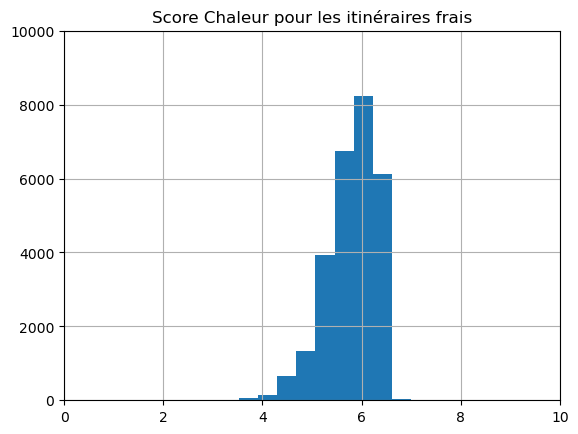

In [56]:
frequency_if["score_08"].hist()
plt.xlim([0,10])
plt.ylim([0,10000])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

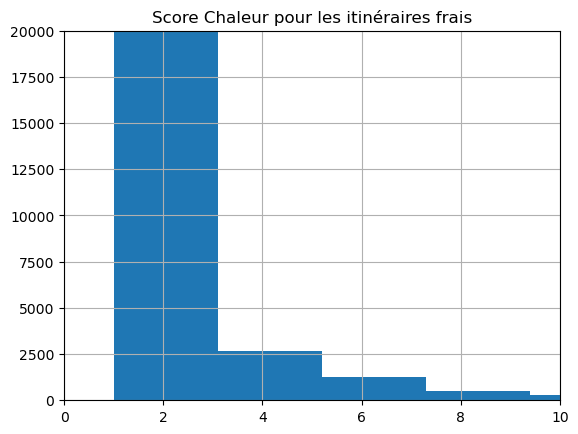

In [57]:
frequency_if["count"].hist()
plt.xlim([0,10])
plt.ylim([0,20000])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

In [58]:
pd.DataFrame(frequency_if["count"]).quantile([0.91]).iloc[0]

count    5.0
Name: 0.91, dtype: float64

Si on regarde la population des 10% segments les plus fréquentés

In [59]:
most_frequent_if = frequency_if[frequency_if["count"] >= 6]

In [60]:
print(len(frequency_if))
print(len(most_frequent_if))

print(round(len(most_frequent_if)/len(frequency_if),2))

27254
2376
0.09


In [61]:
frequency_if.head()

count  score_08  score_13  score_18  \
u       v          key                                        
143403  21714981   0        1     5.811     5.811     5.811   
143408  21714980   0        1     6.261     5.981     6.261   
        9226929620 0        1     6.031     6.031     6.031   
7387347 7387405    0        1     5.946     6.186     5.466   
7387405 8555965    0        1     6.192     6.192     6.102   

                                                                 geometry  
u       v          key                                                     
143403  21714981   0      LINESTRING (4.87739 45.73379, 4.87754 45.73383)  
143408  21714980   0      LINESTRING (4.87633 45.73413, 4.87634 45.73421)  
        9226929620 0      LINESTRING (4.87655 45.73414, 4.87634 45.73421)  
7387347 7387405    0      LINESTRING (4.78169 45.74564, 4.78236 45.74629)  
7387405 8555965    0    LINESTRING (4.78208 45.74539, 4.78198 45.74547...

In [71]:
most_frequent_if_index = select_most_frequent_index(frequency_if, 0.9)
print(most_frequent_if_index)

percent most frequent : 12.522932413590665
[(7394820, 9257232, 0), (7394910, 7394925, 0), (7394910, 33149220, 0), (7394925, 7394910, 0), (7394925, 8207506, 0), (7394925, 1576880256, 0), (7394925, 2115677318, 0), (8206700, 8698408, 0), (8206700, 1374638719, 0), (8207199, 1374638719, 0), (8207199, 1847089768, 0), (8207493, 2472123514, 0), (8207493, 3302622615, 0), (8207506, 7394925, 0), (8207506, 2472123514, 0), (8209560, 1847303223, 0), (8433662, 3088003665, 0), (8433662, 6366705315, 0), (8433684, 33195204, 0), (8433684, 33195208, 0), (8433808, 4942374620, 0), (8434031, 33118776, 0), (8434042, 25470101, 0), (8592437, 9249417, 0), (8592437, 24289066, 0), (8593279, 492150264, 0), (8593425, 1581585126, 0), (8698408, 8206700, 0), (8698408, 1853381937, 0), (8703997, 265783527, 0), (8703998, 265783558, 0), (8876498, 8876507, 0), (8876507, 8593425, 0), (8876974, 1847214286, 0), (8877429, 504557606, 0), (8897028, 34917484, 0), (8897084, 35792706, 0), (8897115, 8897084, 0), (8897358, 4643196447,

In [75]:
index_filter = edges_prop.index.isin(most_frequent_if_index)
print(len(frequency_if))
print(len(most_frequent_if_index))
print(len(index_filter))

27254
3413
164647


In [79]:
edges_prop_most_frequent_if = edges_prop.loc[most_frequent_if_index]

KeyError: '[(7394925, 7394910, 0), (8207199, 1374638719, 0), (8207506, 7394925, 0), (8433808, 4942374620, 0), (8698408, 8206700, 0), (8703998, 265783558, 0), (8876498, 8876507, 0), (8876507, 8593425, 0), (8897084, 35792706, 0), (8897115, 8897084, 0), (8904680, 8897358, 0), (9016091, 8904680, 0), (9257226, 9257232, 0), (9257232, 7394820, 0), (9468865, 9468882, 0), (21378019, 21320769, 0), (21378020, 21378019, 0), (21378022, 801721949, 0), (21378024, 1636008740, 0), (21510486, 21510484, 0), (21510488, 21510476, 0), (21674841, 21674813, 0), (21717932, 21717934, 0), (21717934, 21717927, 0), (22157880, 9249843, 0), (24644270, 24644242, 0), (24644404, 2297011292, 0), (25115178, 25115153, 0), (25303801, 25303796, 0), (25611212, 25611211, 0), (25721817, 1975024455, 0), (25721818, 25721817, 0), (25722274, 25722271, 0), (25733776, 24644242, 0), (25984648, 8857312876, 0), (26149145, 26149144, 0), (26149147, 26149145, 0), (26149148, 4150019144, 0), (26149158, 26149156, 0), (26149158, 26149165, 0), (26149166, 26149165, 0), (26149172, 26149166, 0), (26155374, 26155373, 0), (26155374, 26155375, 0), (26155375, 26149172, 0), (26155423, 26155421, 0), (26155424, 8701078986, 0), (26155498, 26155421, 0), (26314979, 22157880, 0), (26464254, 26464255, 0), (26464255, 25610709, 0), (26464299, 26464253, 0), (26464311, 365117223, 0), (26464312, 26464313, 0), (26464314, 28973822, 0), (26464319, 388568803, 0), (26464321, 26464319, 0), (26464322, 26464314, 0), (27179939, 21510484, 0), (28973822, 26464313, 0), (29873563, 29873562, 0), (29873564, 29873563, 0), (29873565, 29873564, 0), (29873566, 29873565, 0), (31918168, 31918166, 0), (31918173, 31918166, 0), (31920090, 31920075, 0), (31924460, 31924481, 0), (31927209, 31927205, 0), (32020911, 2423149427, 0), (32585614, 32585687, 0), (32585617, 32585614, 0), (32651003, 32651002, 0), (33116037, 8592437, 0), (33122291, 7713655563, 0), (33126059, 10294860763, 0), (33126063, 3060493158, 0), (33148273, 33126063, 0), (33149220, 7394910, 0), (33195199, 33195204, 0), (33195199, 6366705315, 0), (33195204, 8433684, 0), (33195208, 8433684, 0), (33254622, 25248947, 0), (33779900, 33779898, 0), (33779901, 33779900, 0), (33779901, 33779903, 0), (34209843, 881018065, 0), (34500612, 884223135, 0), (34595775, 1936116573, 0), (34595782, 1496489775, 0), (34648986, 25470103, 0), (34829036, 34829035, 0), (34829088, 34829086, 0), (34967271, 4528920830, 0), (34967273, 34967274, 0), (35291576, 35221965, 0), (35408674, 35408672, 0), (35408682, 35408674, 0), (35408688, 35408682, 0), (35792706, 8897028, 0), (35960757, 21510488, 0), (35960758, 35960757, 0), (35960758, 832449681, 0), (36163534, 2110855926, 0), (38609168, 38609154, 0), (42358879, 21495644, 0), (46683697, 1130893878, 0), (46683879, 21495644, 0), (50689885, 50689878, 0), (50801141, 42358700, 0), (50801144, 5985521865, 0), (50801174, 1032852458, 0), (54615245, 54615242, 0), (54661029, 54661040, 0), (54661040, 21495648, 0), (54661062, 2824402090, 0), (54661064, 54615245, 0), (54661066, 54661064, 0), (54661837, 50689890, 0), (54661842, 54661062, 0), (55417152, 55417095, 0), (55444164, 55417074, 0), (55444208, 6360490726, 0), (55457375, 2449859014, 0), (55457380, 6481156622, 0), (57101489, 1815886481, 0), (57101497, 57101489, 0), (59865432, 1032852358, 0), (59865434, 1032852484, 0), (59865444, 59865434, 0), (59865457, 59865449, 0), (60079964, 4582158046, 0), (60374037, 50801144, 0), (60374037, 1032852477, 0), (60374042, 46683879, 0), (60492194, 25932598, 0), (60492200, 190951192, 0), (60492200, 5408278343, 0), (60756036, 60756032, 0), (60756096, 25932633, 0), (60901945, 60901944, 0), (60935370, 60935359, 0), (60935370, 60935369, 0), (60936746, 25722274, 0), (60956835, 55417095, 0), (60956835, 7553874199, 0), (74900185, 74898103, 0), (74900532, 74900185, 0), (74943438, 74898103, 0), (75241093, 75241089, 0), (75365417, 75365510, 0), (75365510, 75364465, 0), (75365945, 75364465, 0), (75365945, 75364471, 0), (75367734, 75364471, 0), (75372916, 87291900, 0), (75373365, 75373367, 0), (75373367, 74900532, 0), (75374105, 75372916, 0), (75374525, 75374590, 0), (75374590, 75374105, 0), (75377390, 1989336555, 0), (75770471, 50063138, 0), (86105944, 915443007, 0), (87292034, 75230189, 0), (91227897, 75231507, 0), (91227897, 1038102936, 0), (91227897, 4691505806, 0), (130144387, 130144297, 0), (130144389, 130144387, 0), (172947861, 431092338, 0), (172947872, 172947870, 0), (172947874, 172947872, 0), (172947878, 172947874, 0), (172947881, 59315131, 0), (172947884, 172947881, 0), (190131566, 36831042, 0), (190903087, 190903058, 0), (190903095, 190903087, 0), (190951192, 60492194, 0), (190951198, 2755567461, 0), (190951229, 190951290, 0), (190951275, 25932596, 0), (190951290, 190903037, 0), (190951520, 190903123, 0), (191134374, 34829073, 0), (191134701, 191134535, 0), (194605193, 21715067, 0), (194605197, 2972411822, 0), (194605210, 194605205, 0), (194605223, 194605210, 0), (194605227, 194605223, 0), (194605232, 194605227, 0), (196233292, 33779898, 0), (196233326, 196233323, 0), (197288356, 8939481773, 0), (197288360, 197288356, 0), (197288363, 1608264170, 0), (197288407, 197288404, 0), (197288416, 197288407, 0), (197288437, 196233326, 0), (197288454, 197288404, 0), (197296239, 197288416, 0), (197296239, 197288417, 0), (197296275, 197296239, 0), (197296275, 1367235590, 0), (197310502, 197310497, 0), (197722196, 2018735111, 0), (197849770, 33779903, 0), (197849777, 197849770, 0), (197849777, 3230095642, 0), (197849825, 197849677, 0), (239603465, 191134387, 0), (240470316, 239603465, 0), (240470324, 191134387, 0), (242163354, 21674841, 0), (243090423, 191134533, 0), (243090468, 243090465, 0), (243522855, 243522986, 0), (243522986, 243522820, 0), (243523057, 243522855, 0), (244499793, 2282355422, 0), (244500310, 8898557577, 0), (244500318, 244500312, 0), (244509493, 244500318, 0), (249359702, 75770471, 0), (249359708, 5037354633, 0), (249634094, 249634089, 0), (249634118, 2348518997, 0), (252502666, 252502662, 0), (252502666, 7460814592, 0), (252502670, 373205533, 0), (252502670, 2865915271, 0), (253417303, 130144297, 0), (253417303, 130144386, 0), (257061763, 25733769, 0), (257882080, 10029783070, 0), (257882086, 6474505735, 0), (258187332, 7065543701, 0), (259978443, 259978442, 0), (262860522, 25115178, 0), (265783501, 3862599153, 0), (265783501, 8976826181, 0), (265783558, 8703997, 0), (270473914, 25327118, 0), (270517756, 631455510, 0), (270517756, 1688841402, 0), (270524273, 270313477, 0), (271207643, 271638798, 0), (271207654, 271207657, 0), (271207657, 270524273, 0), (271207669, 271207654, 0), (281621678, 281621675, 0), (342906618, 342907028, 0), (342907028, 190903095, 0), (343686185, 205317152, 0), (364797085, 364796997, 0), (364797086, 364797085, 0), (364797087, 364797086, 0), (364819700, 1373807743, 0), (365086537, 26155370, 0), (365086537, 26155373, 0), (365117223, 26464252, 0), (366686275, 1557527939, 0), (366804263, 364797087, 0), (368987951, 669863685, 0), (373205533, 130144389, 0), (373847314, 346264851, 0), (388568803, 26155498, 0), (392753301, 249634089, 0), (407800814, 407800831, 0), (407800814, 6404012657, 0), (407800831, 60078292, 0), (411888920, 429428854, 0), (412050298, 1479997643, 0), (412050323, 412050298, 0), (412398845, 9442735268, 0), (412399813, 59315131, 0), (414591563, 538188575, 0), (414719275, 414719342, 0), (414719342, 60756073, 0), (429426800, 429426799, 0), (429428636, 429426799, 0), (429428644, 7062710206, 0), (429428854, 59315131, 0), (429432618, 431097242, 0), (429569354, 266044001, 0), (431092338, 172947824, 0), (431096514, 429432618, 0), (431117666, 2059941883, 0), (434308458, 25303801, 0), (435047407, 430143377, 0), (435100894, 435047407, 0), (437519830, 29873571, 0), (457052904, 7162258061, 0), (457052908, 457052904, 0), (471133022, 21717932, 0), (475552810, 475552808, 0), (475552810, 2180817635, 0), (486022515, 8593279, 0), (496809025, 496809023, 0), (504520948, 24289061, 0), (504557606, 486022515, 0), (517293439, 516085173, 0), (517293440, 516085173, 0), (517293441, 32565259, 0), (517293450, 32565259, 0), (519413788, 519413791, 0), (519413791, 34595965, 0), (529883148, 1565440406, 0), (529888207, 529888194, 0), (529888237, 1453915304, 0), (529894899, 371419382, 0), (529894978, 1342172110, 0), (529894981, 529883145, 0), (536624245, 536624247, 0), (538183985, 4662615383, 0), (538183992, 538183985, 0), (538183992, 1119419696, 0), (538184003, 569071277, 0), (538184019, 538183999, 0), (538188554, 4662615023, 0), (538188558, 538188556, 0), (538188558, 538188627, 0), (538188627, 371419382, 0), (545999653, 1353763828, 0), (545999774, 545999653, 0), (546310156, 10665140762, 0), (546310259, 546310248, 0), (546310269, 546310259, 0), (546322349, 546310248, 0), (546374712, 546374699, 0), (546374776, 546374712, 0), (546374776, 546418629, 0), (546374929, 546374898, 0), (546393867, 538184019, 0), (546394167, 6555694566, 0), (546394217, 529894899, 0), (546394744, 538175783, 0), (546418291, 546418260, 0), (546418387, 569070820, 0), (546418629, 546394217, 0), (557232163, 557232162, 0), (557236182, 2444309442, 0), (557236183, 557236182, 0), (569062588, 569062590, 0), (569062735, 569062588, 0), (569062876, 414591552, 0), (569070607, 833897580, 0), (569070608, 546394167, 0), (569070615, 546394217, 0), (569070615, 569070608, 0), (569071271, 443641346, 0), (569071277, 538183995, 0), (588236358, 588236359, 0), (588236359, 266044810, 0), (624172874, 26149142, 0), (624172877, 25611209, 0), (624172892, 25611211, 0), (624172901, 2284488019, 0), (635876914, 1403175472, 0), (643381244, 21674840, 0), (644880770, 21715353, 0), (645317973, 634360064, 0), (645317977, 645317973, 0), (645317981, 645317973, 0), (645317981, 3017934023, 0), (646784798, 364819700, 0), (646784798, 366804263, 0), (654040314, 387802785, 0), (659471318, 8560770412, 0), (669863660, 345619576, 0), (669863685, 355641861, 0), (718634123, 718634125, 0), (718634125, 588236358, 0), (746600561, 6525588281, 0), (750599762, 3279200513, 0), (761227175, 31924460, 0), (761227181, 31924452, 0), (761227181, 1936111519, 0), (801721949, 21378020, 0), (830323944, 1124950515, 0), (831557317, 831557378, 0), (833897580, 569070595, 0), (878709484, 1444440112, 0), (878760219, 1444465199, 0), (878764570, 878760219, 0), (878781320, 2199185992, 0), (878827618, 1584980269, 0), (878980615, 878980895, 0), (878980622, 878980615, 0), (878980628, 9929727113, 0), (878982116, 1444414973, 0), (880338397, 1585613919, 0), (880338401, 880338397, 0), (880338401, 9933964908, 0), (880338401, 9934005455, 0), (880340028, 1585613919, 0), (881018065, 34209841, 0), (884223135, 34500610, 0), (884223138, 34500612, 0), (911898276, 59865442, 0), (911898314, 59865442, 0), (914248469, 914248471, 0), (914248469, 7298736722, 0), (914248471, 914248472, 0), (914248472, 250554510, 0), (914294427, 1444414973, 0), (914294427, 8084963392, 0), (914298240, 50037590, 0), (914298240, 517293450, 0), (915443007, 75770421, 0), (918094152, 8818930771, 0), (918360857, 1356159902, 0), (918360875, 3298925985, 0), (931679278, 531345259, 0), (1026030646, 8149468697, 0), (1026298821, 1026298845, 0), (1026298825, 249359708, 0), (1026298845, 1026298771, 0), (1032852321, 50689890, 0), (1032852321, 50801174, 0), (1032852358, 54661842, 0), (1032852458, 50689885, 0), (1032852477, 42358879, 0), (1032852484, 59865432, 0), (1037257273, 3843012934, 0), (1037257310, 3887830537, 0), (1037302518, 75374525, 0), (1037302518, 87292034, 0), (1037302547, 7555026864, 0), (1037316333, 496809023, 0), (1037333133, 1037333038, 0), (1037333410, 1037333133, 0), (1037365024, 75241093, 0), (1037388559, 1037388624, 0), (1037388624, 661076934, 0), (1037388635, 1037388568, 0), (1038058425, 1037257221, 0), (1038058425, 1989391296, 0), (1038058456, 1037257221, 0), (1038058464, 1038058456, 0), (1038058464, 5657136839, 0), (1038063254, 496809025, 0), (1038063254, 496809028, 0), (1038064942, 6657910263, 0), (1038064942, 6657918085, 0), (1038064951, 1038358197, 0), (1038064994, 75232717, 0), (1038065041, 75231509, 0), (1038065184, 1037302547, 0), (1038102936, 75231509, 0), (1038102950, 1038064994, 0), (1038102950, 1038065041, 0), (1038102965, 1604866968, 0), (1038199530, 4791704033, 0), (1038204556, 1038584382, 0), (1038212604, 309310080, 0), (1038213453, 1038212604, 0), (1038274107, 1038123528, 0), (1038274107, 1038274138, 0), (1038274138, 529459747, 0), (1038274161, 1038274127, 0), (1038274161, 5657136571, 0), (1038274197, 2180862940, 0), (1038274200, 1038274097, 0), (1038276489, 1038274134, 0), (1038276532, 9148463900, 0), (1038279056, 309310045, 0), (1038279073, 309310045, 0), (1038353304, 91228797, 0), (1038353338, 1038353283, 0), (1038353425, 1038353338, 0), (1038358165, 1038064951, 0), (1038358165, 3377293887, 0), (1038358197, 475552803, 0), (1038572980, 660608969, 0), (1038573035, 1038573106, 0), (1038573037, 1038573101, 0), (1038573083, 1038573037, 0), (1038573101, 1038573035, 0), (1038573321, 1038573106, 0), (1038584382, 1038199530, 0), (1038594839, 1038573083, 0), (1042406947, 1038213453, 0), (1042406954, 1042406922, 0), (1042406954, 1042406947, 0), (1109068215, 196233323, 0), (1109068215, 6477428920, 0), (1110196664, 618740812, 0), (1110196664, 1110196675, 0), (1110196675, 546310269, 0), (1117219690, 546323409, 0), (1117737255, 546310248, 0), (1117737255, 1117737821, 0), (1117737457, 1117737821, 0), (1119419696, 266044079, 0), (1119419795, 1117737457, 0), (1119419795, 2421522983, 0), (1124830811, 830323944, 0), (1124830811, 1124831026, 0), (1124831026, 618740812, 0), (1124950515, 546310156, 0), (1126334642, 25248947, 0), (1127989199, 546323343, 0), (1140933676, 4692646561, 0), (1163787998, 517293431, 0), (1163788043, 517293414, 0), (1177036460, 2388262372, 0), (1177036555, 1177037039, 0), (1177037174, 54661842, 0), (1177532153, 2600713598, 0), (1177532153, 2600713612, 0), (1178785251, 8818930770, 0), (1180379051, 918094180, 0), (1180379100, 86107404, 0), (1205637162, 1205637172, 0), (1205637163, 1205637162, 0), (1205637163, 3121701490, 0), (1205637172, 1047681918, 0), (1209359257, 32549279, 0), (1216117333, 6239259766, 0), (1241390436, 1241390406, 0), (1241796862, 345620958, 0), (1241796887, 1241796862, 0), (1241854615, 643381244, 0), (1306531810, 437008505, 0), (1313906691, 1357458605, 0), (1314883435, 5697432677, 0), (1325635504, 1325635540, 0), (1325635540, 25721818, 0), (1329067733, 2293989366, 0), (1329067772, 1329067733, 0), (1329067772, 3114574477, 0), (1329067775, 1329067746, 0), (1329067852, 1329067775, 0), (1329067864, 3658423255, 0), (1329067878, 1329067746, 0), (1329067885, 1329067798, 0), (1329067890, 1496489839, 0), (1329067899, 1329067852, 0), (1329067899, 3090344541, 0), (1342172110, 529883145, 0), (1349029184, 2830386415, 0), (1349029210, 1349029184, 0), (1353763828, 538184003, 0), (1356159902, 42358634, 0), (1356880710, 1356880756, 0), (1356880744, 1026298821, 0), (1356880756, 1356880744, 0), (1357458596, 8137913140, 0), (1357458599, 21715069, 0), (1357458605, 836850034, 0), (1359023724, 1359023751, 0), (1359023751, 1356880710, 0), (1362204817, 4671100847, 0), (1364923622, 3842221809, 0), (1367325366, 1313906691, 0), (1368913399, 10819635569, 0), (1368913399, 10819635573, 0), (1370403199, 7705828174, 0), (1372605585, 1241390436, 0), (1372605661, 1241390413, 0), (1373807743, 62026941, 0), (1374638719, 8206700, 0), (1377105879, 412111948, 0), (1389351879, 25611156, 0), (1403127402, 1403127438, 0), (1403175472, 634179179, 0), (1412041715, 669863660, 0), (1412101397, 645317874, 0), (1412597506, 5117970343, 0), (1412672600, 3017934023, 0), (1412673341, 673369552, 0), (1412973519, 634360064, 0), (1412973519, 3836141097, 0), (1421018208, 243757854, 0), (1421028863, 9735216053, 0), (1423944677, 32973810, 0), (1425733290, 1423869310, 0), (1437728821, 1437728805, 0), (1437728842, 5396129245, 0), (1437728852, 1437728821, 0), (1437728881, 1437728852, 0), (1437728887, 2565920541, 0), (1437728905, 1437728887, 0), (1438132817, 58584493, 0), (1438316660, 34500610, 0), (1438316660, 197296275, 0), (1444414973, 878794198, 0), (1444440045, 32325557, 0), (1444440112, 250554510, 0), (1444465199, 557232155, 0), (1444503335, 1444465199, 0), (1444503335, 1444503339, 0), (1444503339, 557232162, 0), (1444522934, 2949388991, 0), (1444537076, 880340028, 0), (1445744478, 3920625470, 0), (1453915304, 529888207, 0), (1455334467, 546418291, 0), (1455334498, 4682122702, 0), (1459727275, 5526296739, 0), (1463129997, 2171601568, 0), (1465157984, 4066666123, 0), (1468526786, 8698256, 0), (1479997642, 277269405, 0), (1479997643, 277269405, 0), (1480230654, 35408688, 0), (1488252427, 6968712692, 0), (1491757085, 1997317834, 0), (1492154704, 1492154664, 0), (1496305915, 2819167679, 0), (1496489656, 519413788, 0), (1496489733, 3202843965, 0), (1496489733, 3274395735, 0), (1496489775, 34595768, 0), (1496489834, 1329067746, 0), (1496489839, 1329067730, 0), (1532642598, 878781320, 0), (1532642614, 2209531247, 0), (1533411771, 10095438335, 0), (1534217703, 361643451, 0), (1540551179, 1540551188, 0), (1540551188, 34499743, 0), (1555607743, 529894974, 0), (1565440406, 529883145, 0), (1565440433, 529894967, 0), (1565440433, 546374898, 0), (1576880256, 7394925, 0), (1576919294, 190131566, 0), (1578746675, 8433808, 0), (1580969262, 1580961735, 0), (1581615357, 1581615360, 0), (1581615357, 2472123501, 0), (1581615360, 9213756, 0), (1582411712, 3274395731, 0), (1582411712, 6133452021, 0), (1583892957, 1496489656, 0), (1583892966, 1583892957, 0), (1583892966, 1583892958, 0), (1583892966, 1583892982, 0), (1583892986, 31920064, 0), (1583892991, 1583892982, 0), (1583892991, 1583892998, 0), (1583892998, 1496305915, 0), (1583942994, 1583892958, 0), (1583966256, 4059475321, 0), (1583980145, 4059475382, 0), (1583988701, 4059553751, 0), (1583988740, 1492154704, 0), (1583988740, 4059459042, 0), (1583990506, 1496305917, 0), (1583995578, 1583995576, 0), (1583995584, 31920057, 0), (1584974434, 878831554, 0), (1584980269, 878826710, 0), (1585587738, 878980895, 0), (1585587743, 5512451168, 0), (1585607401, 557232170, 0), (1585607401, 9934005455, 0), (1585607401, 9938163008, 0), (1588190700, 517293385, 0), (1588234779, 517293440, 0), (1588234779, 517293441, 0), (1604866968, 1037388635, 0), (1607351514, 1607351516, 0), (1607351522, 1607351515, 0), (1608264170, 197288360, 0), (1608298589, 10303206689, 0), (1608305841, 2002554416, 0), (1623954328, 2216507453, 0), (1636008673, 5471749082, 0), (1636008740, 21378022, 0), (1637473467, 1819470751, 0), (1656286396, 1468818336, 0), (1669875470, 1819814931, 0), (1699119115, 197288437, 0), (1699119115, 197288454, 0), (1700866674, 569062662, 0), (1709557727, 538183999, 0), (1709557739, 1488252427, 0), (1709557739, 1709557727, 0), (1719261340, 6127806040, 0), (1748226580, 1748226564, 0), (1748226580, 4671100809, 0), (1815886481, 55417152, 0), (1819470751, 34499782, 0), (1819814934, 25984648, 0), (1847303223, 8209560, 0), (1848931840, 3678142799, 0), (1848931922, 5686130775, 0), (1848932074, 1848932051, 0), (1852659168, 36163534, 0), (1852659168, 1847303223, 0), (1852659192, 25312477, 0), (1853366926, 7453232198, 0), (1853366955, 1853366958, 0), (1853366958, 1853366926, 0), (1853381949, 7453232198, 0), (1855582466, 75230193, 0), (1866814355, 35792712, 0), (1873957273, 7395110, 0), (1873957276, 8209633, 0), (1873957298, 8209560, 0), (1909893968, 1909916294, 0), (1935182265, 2471721033, 0), (1936111534, 2819168467, 0), (1936111534, 3274388716, 0), (1936115732, 1936116156, 0), (1936115732, 4054245591, 0), (1936116156, 34595775, 0), (1936116573, 34595774, 0), (1937564523, 5193768108, 0), (1937565836, 1937564523, 0), (1937565836, 5700701430, 0), (1937781186, 3706927585, 0), (1975024430, 392753301, 0), (1975024433, 1975024430, 0), (1975024452, 60936576, 0), (1975122199, 32973810, 0), (1987679606, 1037257327, 0), (1987679650, 1987679638, 0), (1987679759, 1987679755, 0), (1987679793, 1987679796, 0), (1987679796, 75367734, 0), (1988297183, 1325635504, 0), (1989336555, 75372916, 0), (1989391296, 75377390, 0), (1996895461, 1996895459, 0), (1996895464, 2004791409, 0), (1997317822, 1997317824, 0), (1997317824, 1491757085, 0), (1997362282, 2168139410, 0), (2002537208, 2002537194, 0), (2002537214, 1996895459, 0), (2002537230, 2002537208, 0), (2002537230, 2002554401, 0), (2002537236, 2002537194, 0), (2002537236, 2002537214, 0), (2002554392, 2024714232, 0), (2002554393, 197849825, 0), (2002554405, 1608305841, 0), (2002554410, 2002554392, 0), (2002554436, 2002554401, 0), (2004791409, 1608298589, 0), (2006041042, 2006041045, 0), (2006041042, 2006041048, 0), (2006041045, 197849677, 0), (2006041048, 197849718, 0), (2015330074, 259977346, 0), (2018719128, 644880770, 0), (2018719128, 3393859837, 0), (2018735111, 33780066, 0), (2024714232, 2002554393, 0), (2076029038, 1576919294, 0), (2110855912, 1852659192, 0), (2115677293, 36163534, 0), (2115677299, 9257214, 0), (2115677299, 2115677318, 0), (2115677318, 7394925, 0), (2131984937, 4140633803, 0), (2168139410, 531345234, 0), (2171601559, 249634114, 0), (2171601559, 2171601568, 0), (2178005052, 7329828073, 0), (2178005052, 9498928760, 0), (2178005059, 1038572980, 0), (2180817635, 2180817652, 0), (2180817641, 309310062, 0), (2180817652, 309310056, 0), (2180817652, 2180817635, 0), (2180819941, 2180817641, 0), (2180819941, 2180819942, 0), (2180819942, 2180817652, 0), (2180824076, 309310062, 0), (2180824083, 2180835072, 0), (2180824083, 2180835078, 0), (2180835069, 2180835074, 0), (2180835072, 1038573321, 0), (2180835073, 2178010235, 0), (2180835075, 2180824076, 0), (2180835075, 2180835069, 0), (2180835075, 2180835078, 0), (2180835078, 529459747, 0), (2180862936, 1038274197, 0), (2180862940, 1038063239, 0), (2180871823, 1038063239, 0), (2180871823, 1038274073, 0), (2180871827, 1038274073, 0), (2180871827, 1038274127, 0), (2180887701, 2180862936, 0), (2180887703, 1038274157, 0), (2180888732, 2180862938, 0), (2180889700, 2180862938, 0), (2180889700, 2180887696, 0), (2180891383, 5657136564, 0), (2180891384, 2180891383, 0), (2180891384, 5657136554, 0), (2180892135, 9210725296, 0), (2180902120, 2180902118, 0), (2184397569, 309310080, 0), (2199185992, 32585619, 0), (2209531247, 9558832692, 0), (2231891389, 2180893904, 0), (2231891389, 5657136527, 0), (2231891390, 1038279056, 0), (2231891390, 2231891389, 0), (2242814694, 536624245, 0), (2242814705, 2242814694, 0), (2244853552, 546310154, 0), (2244855092, 2244853552, 0), (2269315988, 21495650, 0), (2269315989, 1047681918, 0), (2269316004, 2269315989, 0), (2269316004, 4692646561, 0), (2273352513, 243523057, 0), (2281106294, 9149367276, 0), (2282355422, 194616982, 0), (2284330685, 631455510, 0), (2284330685, 3920625461, 0), (2284330716, 1688841402, 0), (2284330716, 2481163687, 0), (2284488019, 191134429, 0), (2293989366, 29873566, 0), (2293989370, 5686130795, 0), (2297011292, 24644270, 0), (2311058412, 190866507, 0), (2313388561, 59865453, 0), (2313388562, 2313388561, 0), (2320329008, 4073552734, 0), (2338842662, 2293989370, 0), (2338842662, 5686130821, 0), (2348519006, 60950753, 0), (2356830989, 569062876, 0), (2356843447, 1455334467, 0), (2386055702, 911898276, 0), (2388262372, 59865410, 0), (2421522983, 1119419696, 0), (2423149389, 1329067878, 0), (2423149403, 2423149389, 0), (2423149405, 2423149411, 0), (2423149405, 4021869222, 0), (2423149411, 1329067772, 0), (2423149427, 32020906, 0), (2423149440, 3114680400, 0), (2423149448, 4433465230, 0), (2429862902, 529894978, 0), (2444309442, 557236019, 0), (2449859014, 25932599, 0), (2452579576, 1468818336, 0), (2462509537, 33149209, 0), (2462509574, 2462509586, 0), (2462509574, 3131785148, 0), (2462509586, 3130158312, 0), (2471721033, 1607350133, 0), (2472123501, 1576880256, 0), (2472123514, 8207493, 0), (2472123514, 8207506, 0), (2485441673, 2459242853, 0), (2499044375, 2499044376, 0), (2499044376, 1947682920, 0), (2512682817, 564740277, 0), (2512682817, 3905948463, 0), (2565920528, 2565920521, 0), (2565920536, 2565920521, 0), (2565920541, 1437728881, 0), (2600713598, 21510476, 0), (2600713612, 27179938, 0), (2600713625, 27179938, 0), (2600713640, 27179939, 0), (2600713640, 2600713625, 0), (2620091268, 75239252, 0), (2620091268, 1855582466, 0), (2655755892, 26464321, 0), (2655755892, 26464322, 0), (2694721209, 2694721171, 0), (2694721214, 2694721209, 0), (2705418267, 4671100835, 0), (2705418276, 5685921788, 0), (2725019394, 2171479309, 0), (2725019401, 4843891335, 0), (2732697659, 1463129997, 0), (2732697659, 3110165746, 0), (2733733117, 7150535925, 0), (2733733151, 2733733153, 0), (2733733153, 1029591805, 0), (2733733165, 2733733164, 0), (2733733166, 2733733165, 0), (2733733166, 10690397830, 0), (2733733168, 10317007074, 0), (2733733169, 2733733164, 0), (2733733172, 2733733168, 0), (2733733176, 2733733172, 0), (2733733176, 2733733177, 0), (2733733177, 5267104564, 0), (2755567460, 25932591, 0), (2755567460, 1480230654, 0), (2755567460, 2755567461, 0), (2785904723, 2785904725, 0), (2785904725, 249634078, 0), (2819167679, 31920075, 0), (2819168305, 1583990506, 0), (2819168348, 4059459066, 0), (2819168352, 761227175, 0), (2819168359, 31924481, 0), (2819168365, 2819168364, 0), (2819168467, 1936111519, 0), (2819168496, 2819168467, 0), (2819168542, 2819168481, 0), (2819168596, 2819168593, 0), (2819168613, 3657870358, 0), (2819168613, 4478089766, 0), (2819168622, 2819168601, 0), (2819168627, 32020911, 0), (2821517148, 314741099, 0), (2821517153, 2821517148, 0), (2824402090, 54661058, 0), (2842315391, 197310502, 0), (2842340413, 2842315391, 0), (2844224497, 4072684906, 0), (2849313906, 33148273, 0), (2857957367, 243090454, 0), (2857957376, 2857957367, 0), (2864851049, 60901945, 0), (2865151407, 5889096999, 0), (2865915271, 252502662, 0), (2896695569, 29873559, 0), (2905326969, 257061763, 0), (2916105775, 25312373, 0), (2949388991, 34209843, 0), (2955572093, 4478089607, 0), (2972411822, 60901947, 0), (2972411824, 2864851049, 0), (2972411828, 194605193, 0), (3017874899, 1328643299, 0), (3023940085, 4036447702, 0), (3059819857, 1349029245, 0), (3090344541, 1329067810, 0), (3090344544, 1329067890, 0), (3090359683, 1496489839, 0), (3090359683, 3114677542, 0), (3100724898, 1275515292, 0), (3110165746, 249634094, 0), (3114574477, 1329067730, 0), (3114661137, 1329067864, 0), (3114661137, 3114661156, 0), (3114661156, 1329067798, 0), (3114677542, 1329067885, 0), (3114677578, 4433465240, 0), (3114677583, 3114680417, 0), (3114680400, 29873562, 0), (3114680419, 3114677595, 0), (3120180285, 1314883435, 0), (3122553051, 2423149427, 0), (3122553056, 29873559, 0), (3122553056, 32020906, 0), (3130158312, 2462509537, 0), (3131785148, 33195208, 0), (3149804672, 3121838414, 0), (3159214821, 33779876, 0), (3202817579, 1163787998, 0), (3202843965, 31927229, 0), (3210684868, 2725019401, 0), (3210684868, 4844766422, 0), (3230088390, 25932593, 0), (3230095642, 197849718, 0), (3241659204, 2242814705, 0), (3241659207, 3241659204, 0), (3249126901, 3241659207, 0), (3257399258, 2313388562, 0), (3257399259, 2313579204, 0), (3266668773, 34829070, 0), (3274388716, 1936111527, 0), (3274395731, 34595768, 0), (3274395735, 31927209, 0), (3274402981, 34595770, 0), (3279200515, 3279200513, 0), (3279231578, 4361719613, 0), (3290966176, 911898314, 0), (3298925985, 42358704, 0), (3302622615, 8207493, 0), (3315273949, 7555550291, 0), (3343587983, 188471743, 0), (3376526894, 4015522014, 0), (3376533513, 3376526894, 0), (3377293875, 309310056, 0), (3377293875, 3377293877, 0), (3377293879, 1038274157, 0), (3377293879, 3377293877, 0), (3377293881, 475552808, 0), (3377293885, 1038064941, 0), (3377293887, 3377293881, 0), (3393859846, 3393859861, 0), (3402352997, 8491909056, 0), (3402352999, 3402352997, 0), (3402353000, 3402352999, 0), (3402353003, 3402353000, 0), (3402353006, 62026941, 0), (3402353006, 3402353003, 0), (3483933383, 6133452033, 0), (3483933383, 10865597359, 0), (3483934977, 31918173, 0), (3483934977, 31927205, 0), (3531524742, 26464311, 0), (3533823294, 249634114, 0), (3533823294, 249634118, 0), (3598470929, 1038594839, 0), (3599621321, 9542777920, 0), (3599628069, 4146395185, 0), (3599628069, 4146396890, 0), (3633858275, 87293348, 0), (3650709178, 34829088, 0), (3650709178, 4150019141, 0), (3657870359, 2819168627, 0), (3657870359, 3657870358, 0), (3678142799, 9023102725, 0), (3706927585, 3706944234, 0), (3706944234, 414583474, 0), (3707028121, 1436628879, 0), (3715900245, 3715900249, 0), (3715900249, 718634123, 0), (3760025967, 244500310, 0), (3760109138, 8148599279, 0), (3828667620, 914294427, 0), (3833180298, 55444164, 0), (3836141097, 364796997, 0), (3840413118, 60756023, 0), (3842221809, 60756023, 0), (3843012934, 1037257208, 0), (3843012951, 2281106293, 0), (3843118676, 7095878093, 0), (3843118680, 3843118675, 0), (3843118680, 7095878296, 0), (3843118688, 3843118683, 0), (3843241770, 9248698906, 0), (3862599153, 9249843, 0), (3867125893, 25303796, 0), (3887830537, 1037257211, 0), (3890028854, 8149383912, 0), (3896902598, 3896908816, 0), (3896908816, 1107379160, 0), (3905948463, 26464312, 0), (3920625462, 3920625463, 0), (3920625462, 10855768529, 0), (3920625463, 3920609455, 0), (3920625472, 3920625461, 0), (3920625472, 3920625470, 0), (3920625497, 1445744478, 0), (3920625497, 3920609455, 0), (3987467786, 4674699294, 0), (4015522014, 60756096, 0), (4015522015, 25932633, 0), (4015522015, 7062852377, 0), (4015522021, 60756089, 0), (4015522021, 60756096, 0), (4018128563, 529888237, 0), (4021869222, 1329067746, 0), (4036446973, 3257399259, 0), (4054245591, 1936115724, 0), (4056691700, 34967273, 0), (4056691700, 1126334642, 0), (4059448398, 4059448421, 0), (4059448421, 1583988740, 0), (4059448439, 4059452746, 0), (4059452746, 2819168352, 0), (4059457266, 1492154680, 0), (4059459042, 1492154680, 0), (4059459066, 2819168328, 0), (4059468320, 4059553733, 0), (4059468320, 4059553737, 0), (4059468358, 1583995578, 0), (4059468358, 4059475314, 0), (4059475314, 1583980144, 0), (4059475382, 1583980144, 0), (4059475397, 4059585549, 0), (4059490817, 1583958935, 0), (4059490846, 4059490817, 0), (4059490846, 4061233882, 0), (4059492523, 4059448439, 0), (4059492523, 4061230888, 0), (4059553731, 1492154728, 0), (4059553733, 1492154728, 0), (4059553737, 1583995576, 0), (4059553751, 1492154664, 0), (4059565835, 2955572093, 0), (4059565837, 4059457266, 0), (4059565837, 4059565835, 0), (4059571904, 4059627895, 0), (4059571905, 4059571906, 0), (4059571905, 4059627895, 0), (4059585549, 1583966273, 0), (4059627895, 1583958935, 0), (4059853707, 29873562, 0), (4059853707, 2896695569, 0), (4061230888, 2819168305, 0), (4061233882, 1583990506, 0), (4063452952, 4066666105, 0), (4063452973, 1444537076, 0), (4063452974, 4063452973, 0), (4063455237, 557236019, 0), (4063480961, 1465157984, 0), (4063480961, 4063480972, 0), (4063480972, 32585617, 0), (4065295713, 34829059, 0), (4065295727, 34829050, 0), (4066663688, 1444537076, 0), (4066663688, 4063483010, 0), (4066666101, 1444537076, 0), (4066666123, 32585619, 0), (4071615380, 277269434, 0), (4071615387, 4071615380, 0), (4072684906, 25722274, 0), (4073556055, 1585587743, 0), (4073556056, 4073556055, 0), (4075391720, 1349029210, 0), (4098980306, 4098980305, 0), (4098980306, 4099004158, 0), (4098980307, 4098980305, 0), (4098980343, 10658392164, 0), (4099004160, 4099004158, 0), (4103597428, 517293450, 0), (4113584695, 34829050, 0), (4117537743, 34829074, 0), (4117537745, 34829071, 0), (4120944879, 429428644, 0), (4120944881, 4120944879, 0), (4120944881, 7062710202, 0), (4133503016, 1909916292, 0), (4133503016, 4133503024, 0), (4133503024, 1909916294, 0), (4140250393, 34829036, 0), (4140258106, 4140610327, 0), (4140278093, 34829066, 0), (4140288663, 4117537743, 0), (4140320675, 240470324, 0), (4140324242, 4065295713, 0), (4140324242, 4065295727, 0), (4140633803, 34829035, 0), (4146395185, 2115677293, 0), (4146396890, 361643451, 0), (4146396894, 1534217703, 0), (4146396894, 3302622615, 0), (4150019141, 624172892, 0), (4150019142, 25611211, 0), (4150019142, 624172877, 0), (4150019144, 26149147, 0), (4150019147, 25611211, 0), (4150019147, 26149148, 0), (4150019152, 26149148, 0), (4150019175, 25611212, 0), (4150021199, 1370403199, 0), (4150021199, 4150021202, 0), (4150021202, 624172901, 0), (4162715932, 33149209, 0), (4162715932, 33149220, 0), (4165905758, 392751580, 0), (4178835662, 4666690725, 0), (4246258398, 54661040, 0), (4246258398, 1566864061, 0), (4262383779, 4262383788, 0), (4262383785, 4262383778, 0), (4262383803, 1042406922, 0), (4262383803, 4262383785, 0), (4262384149, 10058481587, 0), (4262384151, 4262384149, 0), (4262384161, 3887830686, 0), (4336348029, 1759695679, 0), (4361719613, 1459727275, 0), (4361725176, 3279231578, 0), (4425329028, 25733769, 0), (4425329028, 8856106186, 0), (4433465230, 2423149440, 0), (4433465240, 4433465230, 0), (4478089607, 31924418, 0), (4478089648, 2955572093, 0), (4478089669, 6150441220, 0), (4478089679, 4478089669, 0), (4478089679, 4478089686, 0), (4478089686, 2819168593, 0), (4478089694, 4478089691, 0), (4478089766, 2819168596, 0), (4528920830, 34967269, 0), (4528920841, 34967271, 0), (4528920841, 8976826181, 0), (4529983264, 431092343, 0), (4582158046, 60078286, 0), (4582158423, 3760109139, 0), (4619742911, 33126059, 0), (4639053939, 33116037, 0), (4662615022, 538188555, 0), (4662615022, 538188575, 0), (4662615372, 1455334498, 0), (4662615383, 538175793, 0), (4666689985, 250554542, 0), (4666689987, 250554542, 0), (4666689987, 557232155, 0), (4671100809, 1367235590, 0), (4671100835, 1362204817, 0), (4671100846, 1748226564, 0), (4682122485, 746600561, 0), (4682122485, 6522162627, 0), (4682122702, 443641346, 0), (4690778753, 4747314199, 0), (4690812138, 261634091, 0), (4690812152, 4018128554, 0), (4690812152, 4690812138, 0), (4691505808, 4691505806, 0), (4691505808, 10171693025, 0), (4747314199, 529883148, 0), (4747314259, 569070615, 0), (4756682350, 60079971, 0), (4769880525, 414719275, 0), (4791704033, 21674959, 0), (4796068123, 5793474496, 0), (4816544794, 259977340, 0), (4824803601, 10598657283, 0), (4843891335, 60936746, 0), (4844766422, 2725019394, 0), (4892032201, 4140278093, 0), (4892038440, 4140258106, 0), (4899276207, 4113584695, 0), (4899276207, 4899276211, 0), (4899276211, 4140250393, 0), (4928304266, 8173410515, 0), (4935819234, 4935819243, 0), (4935819243, 8876498, 0), (4942374620, 8433662, 0), (4994830325, 57101497, 0), (5017101125, 3279200515, 0), (5018238776, 1847279323, 0), (5037354633, 249359702, 0), (5169649593, 5169649583, 0), (5169649594, 3059819857, 0), (5169649613, 5169649593, 0), (5169649613, 5169649594, 0), (5193768108, 32225701, 0), (5201010760, 546418260, 0), (5240026067, 2565920536, 0), (5240026067, 2565920541, 0), (5240026086, 2565920528, 0), (5240026346, 5240026354, 0), (5240026346, 6404097001, 0), (5240026354, 32549284, 0), (5267104543, 21715353, 0), (5267104543, 5889096999, 0), (5267104562, 5267104540, 0), (5267104562, 5267104564, 0), (5335906801, 5335910552, 0), (5335910552, 1038274200, 0), (5335910567, 4262384151, 0), (5408278343, 55457380, 0), (5469616932, 5469616924, 0), (5469616932, 5469616942, 0), (5469616942, 517293439, 0), (5471749082, 21320769, 0), (5473558921, 21320731, 0), (5511928307, 1656286396, 0), (5512451168, 1585587738, 0), (5526293298, 32549280, 0), (5526293304, 32549281, 0), (5526293304, 5526293298, 0), (5526296739, 32549281, 0), (5526296777, 4361725176, 0), (5527672632, 75230189, 0), (5527672632, 75230193, 0), (5538728936, 57931158, 0), (5538728936, 5017101125, 0), (5582225668, 190951198, 0), (5582225669, 190951203, 0), (5652145269, 1037302487, 0), (5653522534, 75239252, 0), (5657136011, 2180893912, 0), (5657136011, 5657136577, 0), (5657136525, 5657136858, 0), (5657136527, 1987679606, 0), (5657136539, 5657136845, 0), (5657136541, 2621477328, 0), (5657136556, 2180892135, 0), (5657136556, 5657136554, 0), (5657136560, 5657136581, 0), (5657136564, 5657136565, 0), (5657136565, 6615121938, 0), (5657136577, 5657136590, 0), (5657136581, 2180893912, 0), (5657136590, 2180893904, 0), (5657136832, 1987679606, 0), (5657136838, 5657136539, 0), (5657136838, 5657136846, 0), (5657136845, 1038279073, 0), (5657136846, 5657136525, 0), (5657136847, 5657136839, 0), (5657136847, 5657136858, 0), (5676338079, 205295854, 0), (5676338079, 1423944677, 0), (5683370323, 1607351522, 0), (5685921788, 2288733796, 0), (5686130775, 1848931788, 0), (5686130795, 1848932074, 0), (5686130821, 32225701, 0), (5686130894, 5686130895, 0), (5686130895, 5683370323, 0), (5686130904, 6579917454, 0), (5686130920, 5686130904, 0), (5688972037, 1936115724, 0), (5697432667, 5697432674, 0), (5700701430, 1937564524, 0), (5720917872, 25327117, 0), (5793474496, 1637473467, 0), (5810592034, 3920625462, 0), (5889097047, 5892279918, 0), (5892279918, 21717925, 0), (5970249497, 2386055702, 0), (5970249503, 5970249497, 0), (5970249504, 457052908, 0), (5970249527, 5970249504, 0), (5970249527, 5970249530, 0), (5970249530, 5970249503, 0), (5985521865, 50689890, 0), (6053498571, 4435492035, 0), (6127806040, 58584497, 0), (6133452020, 6133452021, 0), (6133452033, 31918168, 0), (6150441220, 4478089648, 0), (6212514332, 60935359, 0), (6239259766, 366686275, 0), (6239303250, 3149804672, 0), (6253928275, 3290966176, 0), (6258069706, 190951520, 0), (6262117128, 3833180298, 0), (6262118091, 3833180294, 0), (6264266196, 2273352513, 0), (6292883244, 878794193, 0), (6292883250, 1532642598, 0), (6292883250, 6292883244, 0), (6292883265, 878794193, 0), (6292883486, 6292883265, 0), (6292883491, 6292883486, 0), (6292883491, 9933964908, 0), (6292883520, 4063452950, 0), (6292883520, 4066666101, 0), (6342825304, 7018237203, 0), (6350085267, 26120446, 0), (6350085268, 6350085267, 0), (6360490726, 55444180, 0), (6361847992, 2499044373, 0), (6362103445, 55444208, 0), (6366705315, 8433662, 0), (6404012657, 60078286, 0), (6404097001, 750599762, 0), (6433667120, 1026298825, 0), (6442593938, 257882079, 0), (6444920793, 1180379100, 0), (6445288988, 5018238776, 0), (6449877463, 878764570, 0), (6467956583, 52774062, 0), (6467956583, 54661837, 0), (6474505735, 257882085, 0), (6475475763, 10989510652, 0), (6476642253, 2244855092, 0), (6476642253, 7593046596, 0), (6477428920, 196233292, 0), (6481156622, 55457375, 0), (6497284887, 50037590, 0), (6497284887, 60374042, 0), (6522162627, 266044079, 0), (6525588281, 545999774, 0), (6555694566, 443641346, 0), (6579669703, 6362103445, 0), (6579917454, 4433465307, 0), (6602333141, 1909916271, 0), (6615121938, 2180888732, 0), (6657910263, 75232717, 0), (6657918085, 496809028, 0), (6698596073, 130144280, 0), (6763639956, 54661029, 0), (6763639956, 59865453, 0), (6766879702, 5409911270, 0), (6859023585, 6859023586, 0), (6859023586, 9929750469, 0), (6926393537, 4262384111, 0), (6945955296, 6928693528, 0), (6945955300, 6928693531, 0), (6945955303, 6945955304, 0), (6968712692, 266044001, 0), (7012474787, 6928608075, 0), (7012474788, 7012474789, 0), (7012474789, 6900471371, 0), (7012474790, 7012474791, 0), (7012474791, 5473347371, 0), (7018237203, 2503979902, 0), (7062710202, 429428636, 0), (7062710206, 411888922, 0), (7062710216, 411888922, 0), (7062710216, 7104348962, 0), (7062852366, 60756006, 0), (7062852374, 60756089, 0), (7062852374, 7062852366, 0), (7062852377, 60756088, 0), (7065543698, 258187332, 0), (7065543698, 3840413118, 0), (7065543701, 60756088, 0), (7076783061, 194605232, 0), (7079744248, 6262117158, 0), (7095878093, 1987679650, 0), (7095878107, 3843118688, 0), (7095878107, 7095878124, 0), (7095878114, 1987679759, 0), (7095878114, 1987679793, 0), (7095878124, 1987679755, 0), (7095878296, 3843118683, 0), (7104348962, 25932633, 0), (7119814607, 1209359257, 0), (7162258061, 59865444, 0), (7162363583, 6253928275, 0), (7178951312, 7204102658, 0), (7204102658, 362671284, 0), (7204435140, 884223138, 0), (7204435140, 6212514332, 0), (7236599925, 60935507, 0), (7298736709, 1437728805, 0), (7298736722, 878774072, 0), (7329828073, 91229553, 0), (7329857194, 7329857188, 0), (7369647860, 414583370, 0), (7369647886, 7369647860, 0), (7460814592, 130144280, 0), (7504154435, 34829086, 0), (7504154436, 240470316, 0), (7504154436, 7504154435, 0), (7512429009, 505061092, 0), (7512429009, 9879641324, 0), (7512429021, 9880007244, 0), (7550626409, 4336348029, 0), (7550626414, 7550626409, 0), (7550626416, 7550626414, 0), (7550893549, 434308458, 0), (7553874199, 55417074, 0), (7555026864, 1037302486, 0), (7555550291, 35408674, 0), (7593046590, 529894981, 0), (7593046592, 7593046590, 0), (7593046592, 7593046594, 0), (7593046594, 7593046596, 0), (7644575043, 26155370, 0), (7644575045, 7550893549, 0), (7644575045, 7644575043, 0), (7704961584, 1037333410, 0), (7704961584, 5653522534, 0), (7705828174, 4150019175, 0), (7713655563, 27179925, 0), (7847657550, 2002554410, 0), (7847657550, 2002554436, 0), (7886579907, 35408667, 0), (7912088169, 1975024430, 0), (7912088174, 7910020427, 0), (7912088174, 7912088169, 0), (8084963392, 8084963393, 0), (8084963393, 878827618, 0), (8084982752, 3828667620, 0), (8088318345, 3760109138, 0), (8130145338, 257882086, 0), (8137491713, 8137523946, 0), (8137577609, 1357458596, 0), (8137913140, 1313906707, 0), (8148599278, 8148638875, 0), (8148638874, 4582158423, 0), (8149468697, 1026030481, 0), (8149517622, 8149540541, 0), (8149518876, 8149579152, 0), (8149579147, 6239303250, 0), (8149579152, 8149579147, 0), (8149602182, 8149602194, 0), (8149666806, 8149683519, 0), (8164442341, 8164442342, 0), (8164442342, 2733733163, 0), (8164970488, 2972411828, 0), (8168610609, 9257214, 0), (8168610609, 9257226, 0), (8168819570, 4928304266, 0), (8168819577, 3867125893, 0), (8168819577, 8173410515, 0), (8177005550, 172947861, 0), (8243398999, 190903039, 0), (8297976051, 75365417, 0), (8297976092, 8297976051, 0), (8299934927, 32577541, 0), (8355407914, 8355447049, 0), (8355407914, 8355447059, 0), (8355436857, 8951397316, 0), (8355447059, 2389285696, 0), (8402713902, 257882080, 0), (8402713909, 257882085, 0), (8402713909, 8402713902, 0), (8491909056, 2844224497, 0), (8555357025, 6418530131, 0), (8560770412, 242163354, 0), (8569008907, 4756682350, 0), (8650916493, 8650916507, 0), (8650916495, 7886579907, 0), (8650916507, 8650916502, 0), (8650916510, 8650916509, 0), (8650924023, 8650916493, 0), (8662692689, 530528218, 0), (8662692695, 8662692689, 0), (8662692704, 8662692695, 0), (8696374727, 8696374834, 0), (8696431818, 8794696004, 0), (8696457420, 8696431520, 0), (8701078986, 26155423, 0), (8794909313, 8794909311, 0), (8795169932, 2694721214, 0), (8813829924, 8804166655, 0), (8814378955, 8149666793, 0), (8818930770, 918094152, 0), (8818930771, 35126959, 0), (8856106188, 8856106186, 0), (8856106190, 8856106188, 0), (8856106190, 8856106191, 0), (8856106191, 1975122199, 0), (8856370123, 1421018208, 0), (8857154587, 1375968309, 0), (8857312876, 21510486, 0), (8898557577, 244499793, 0), (8910702867, 261634092, 0), (8910724417, 1700866674, 0), (8913570856, 34648986, 0), (8939481773, 197288350, 0), (8951379775, 8355436857, 0), (9023102725, 9250325789, 0), (9045010348, 25733776, 0), (9148463900, 9148463904, 0), (9149367270, 5657136560, 0), (9149367270, 9210725296, 0), (9149367277, 2180902120, 0), (9152567799, 27503214, 0), (9250325779, 3122553051, 0), (9250325779, 9250325789, 0), (9297230108, 191134533, 0), (9337233793, 9337233804, 0), (9337233804, 2002554405, 0), (9442735268, 411888920, 0), (9442745211, 412398845, 0), (9442745211, 7062710206, 0), (9443163211, 431092341, 0), (9443163212, 9443163211, 0), (9443163214, 9443163212, 0), (9498928760, 1038353304, 0), (9528425311, 191134374, 0), (9528425316, 4140320675, 0), (9528425316, 9528425311, 0), (9542777920, 8877429, 0), (9558832692, 32325537, 0), (9629179055, 5652145269, 0), (9643292947, 257882075, 0), (9649067267, 5267104540, 0), (9666214507, 9649067267, 0), (9666214508, 9666214490, 0), (9666214508, 9666214507, 0), (9711480550, 9711480551, 0), (9711480551, 9711480548, 0), (9768379121, 1306531810, 0), (9793587392, 86105934, 0), (9836298781, 10096380937, 0), (9836298783, 10096380939, 0), (9836361615, 9853635411, 0), (9853635411, 9732840177, 0), (9858415198, 9815039662, 0), (9858415200, 9858415198, 0), (9858415202, 9858415200, 0), (9858415204, 9858415202, 0), (9858415206, 9858415204, 0), (9879641324, 191134429, 0), (9880007244, 191134595, 0), (9905893055, 21378024, 0), (9907671134, 10095438340, 0), (9907709403, 9907709406, 0), (9907709403, 11011136023, 0), (9907709406, 8084982752, 0), (9907820656, 1532642598, 0), (9907820656, 9907820676, 0), (9907820676, 878794198, 0), (9929727113, 878980622, 0), (9929750469, 9297230108, 0), (9933603460, 878709484, 0), (9933603460, 4666689985, 0), (9933964246, 6449877463, 0), (9938162990, 557236183, 0), (9938162990, 880333212, 0), (9938163008, 557232163, 0), (10028342935, 10027965704, 0), (10028797869, 1038199371, 0), (10029255161, 4262383778, 0), (10029459036, 1038204556, 0), (10029783037, 6442593938, 0), (10029783037, 9643292947, 0), (10029783070, 257882079, 0), (10058481608, 1038123528, 0), (10058481608, 2184397569, 0), (10058533469, 1038274138, 0), (10058533474, 10058533470, 0), (10083179767, 530794110, 0), (10095438335, 1437728800, 0), (10095438339, 878774072, 0), (10095438377, 10095438339, 0), (10095438377, 10095438340, 0), (10095438381, 7298736709, 0), (10095438381, 10095438340, 0), (10096380937, 9836298773, 0), (10096380939, 9836298781, 0), (10108708164, 3252041057, 0), (10171693025, 475552803, 0), (10185920963, 21717934, 0), (10275543931, 7076783061, 0), (10294860763, 25114928, 0), (10294860766, 262860522, 0), (10300639292, 5153307749, 0), (10303206681, 1617930305, 0), (10303206689, 196071621, 0), (10317007074, 2733733163, 0), (10539887427, 10819635565, 0), (10582032093, 10807028984, 0), (10598657283, 1835841713, 0), (10598657297, 4824803601, 0), (10603835468, 271207669, 0), (10603835468, 2171479309, 0), (10658391088, 4098980337, 0), (10658391090, 10658391088, 0), (10658391094, 4098980336, 0), (10658391096, 10658391094, 0), (10658392156, 10658392078, 0), (10658392164, 4098980337, 0), (10658392240, 10658392310, 0), (10658392242, 10658392240, 0), (10658392244, 10658392242, 0), (10658392246, 10658392244, 0), (10658392249, 10658392246, 0), (10658392252, 10658392249, 0), (10658392255, 10658392252, 0), (10658392258, 10658392255, 0), (10658392261, 10658392258, 0), (10658392269, 10658392261, 0), (10658392272, 10658392269, 0), (10658392275, 10658392272, 0), (10658392280, 10658392278, 0), (10658392280, 10658392282, 0), (10658392282, 10658392275, 0), (10658392290, 10658392309, 0), (10658392292, 10658392302, 0), (10658392298, 87291900, 0), (10658392299, 10658392292, 0), (10658392302, 10658392290, 0), (10658392308, 10658392298, 0), (10658392308, 10658392299, 0), (10658392309, 10658392311, 0), (10658392310, 4098980337, 0), (10658392311, 10658392278, 0), (10658862767, 7550626416, 0), (10658873953, 1815886481, 0), (10661607212, 6254080758, 0), (10665140761, 10665140762, 0), (10665140762, 546310154, 0), (10665162634, 10665140761, 0), (10690397830, 564740277, 0), (10726160826, 3257399258, 0), (10726160826, 4036446976, 0), (10751726164, 1177036293, 0), (10751842194, 2819168553, 0), (10751842194, 10751842613, 0), (10751842613, 1496489834, 0), (10819635553, 9735216051, 0), (10819635555, 10819635557, 0), (10819635557, 5676338079, 0), (10819635565, 1421028863, 0), (10819635569, 205295854, 0), (10823972070, 4020676713, 0), (10823972085, 8149483554, 0), (10823972089, 10823972112, 0), (10823972091, 10823972085, 0), (10823972093, 8149483550, 0), (10823972109, 1026030646, 0), (10841533059, 1468818336, 0), (10841533059, 2481163687, 0), (10855768529, 2905326969, 0), (10864789071, 26022694, 0), (10864789071, 9045010348, 0), (10865597351, 10865597357, 0), (10865597352, 10865597361, 0), (10865597359, 31920090, 0), (10865597361, 10865597359, 0), (10865597372, 10865597390, 0), (10865597390, 6133452020, 0), (10866859104, 5511928307, 0), (10866859104, 6698596073, 0), (10909154926, 245023120, 0), (10989510652, 21378033, 0), (11011136023, 9907671134, 0)] not in index'